In [9]:
import numpy as np
import pandas as pd
import pickle
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import yaml

pd.set_option("display.max_columns", None) # 表示する列数の制限を解除

In [15]:
with open(r"C:\\Users\\yasak\\Desktop\\mykeibaAI\\data\\merged_table_260124.pkl", "rb") as f:
    # "C:\Users\yasak\デスクトップ\Keiba_App\mykeibaAI_ver1p0\data\merged_table.pkl" # NotePC用フォルダパス
    # "C:\\Users\\yasak\\Desktop\\mykeibaAI\\data\\merged_table.pkl" # Desktop用フォルダパス
    model = pickle.load(f)

print(model.columns)
print(f"Number of items: {len(model.columns)}")
print(f"Number of rows: {len(model)}")

Index(['date', 'race_id', 'is_win', 'rank', 'horse_id', 'weight_carried',
       'jockey_id', 'popularity', 'odds', 'last3f', 'trainer_id',
       'body_weight', 'sex', 'age', 'time_sec', 'body_diff', 'weight',
       'weather', 'num_of_horses', 'course_condition', 'course_state',
       'distance_length', 'race_course_code', 'log_odds_avg3', 'log_odds_avg5',
       'log_odds_avg10', 'log_odds_zscore_avg3', 'log_odds_zscore_avg5',
       'log_odds_zscore_avg10', 'popularity_inverse_avg3',
       'popularity_inverse_avg5', 'popularity_inverse_avg10',
       'popularity_bucket_avg3', 'popularity_bucket_avg5',
       'popularity_bucket_avg10', 'weight_minus_avg_in_race',
       'weight_per_body_weight', 'finish_position_inverse_avg3',
       'finish_position_inverse_avg5', 'finish_position_inverse_avg10',
       'expected_vs_actual_gap_avg3', 'expected_vs_actual_gap_avg5',
       'expected_vs_actual_gap_avg10', 'time_diff_from_winner_avg3',
       'time_diff_from_winner_avg5', 'time_diff_

In [16]:
with open(r'C:\Users\yasak\Desktop\mykeibaAI\code\features.yaml', 'r', encoding='utf-8') as f:
    data = yaml.safe_load(f)
    features = data['features']
    features = [f for f in data['features'] if f not in ['horse_id', 'race_id']]  # horse_idとrace_idを除外
X = model[features]
y = model['is_win']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [18]:
params = {
    'objective': 'binary', # 2クラス分類
    'metric': 'binary_logloss', # ロス関数
    'boosting_type': 'gbdt', # 勾配ブースティング
    'learning_rate': 0.1, # 学習率(小さいほど慎重に学習、ただし学習時間は長くなる)
    'num_leaves': 31, # 木の葉の数(複雑なモデルほど大きく)
    'verbose': -1, # 全てのログの出力を非表示
    'early_stopping_round': 30, # 30回連続で改善しなければ終了
    'num_boost_round': 300 # 最大100本の木を作成
}

In [19]:
ml_model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval], valid_names=['train', 'eval'])
y_pred_prob = ml_model.predict(X_test, num_iteration=ml_model.best_iteration)
y_pred = (y_pred_prob >= 0.5).astype(int) # 確率を0.5で閾値判定
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

results = X_test.copy() # 学習データ
results["actual"] = y_test # 実際の予測対象
results["predicted"] = y_pred # 予測結果
results["predicted_prob"] = y_pred_prob # 予測確率

results.head(10)

Accuracy: 92.65%


,weight,weather,num_of_horses,course_condition,course_state,distance_length,race_course_code,log_odds_avg3,log_odds_avg5,log_odds_avg10,log_odds_zscore_avg3,log_odds_zscore_avg5,log_odds_zscore_avg10,popularity_inverse_avg3,popularity_inverse_avg5,popularity_inverse_avg10,popularity_bucket_avg3,popularity_bucket_avg5,popularity_bucket_avg10,weight_minus_avg_in_race,weight_per_body_weight,finish_position_inverse_avg3,finish_position_inverse_avg5,finish_position_inverse_avg10,expected_vs_actual_gap_avg3,expected_vs_actual_gap_avg5,expected_vs_actual_gap_avg10,time_diff_from_winner_avg3,time_diff_from_winner_avg5,time_diff_from_winner_avg10,time_zscore_in_race_avg3,time_zscore_in_race_avg5,time_zscore_in_race_avg10,final_3f_rank_avg3,final_3f_rank_avg5,final_3f_rank_avg10,final_3f_diff_avg3,final_3f_diff_avg5,final_3f_diff_avg10,final_3f_zscore_avg3,final_3f_zscore_avg5,final_3f_zscore_avg10,log_prize_avg3,log_prize_avg5,log_prize_avg10,passing_1st_rel_avg3,passing_1st_rel_avg5,passing_1st_rel_avg10,passing_2nd_rel_avg3,passing_2nd_rel_avg5,passing_2nd_rel_avg10,passing_3rd_rel_avg3,passing_3rd_rel_avg5,passing_3rd_rel_avg10,passing_4th_rel_avg3,passing_4th_rel_avg5,passing_4th_rel_avg10,actual,predicted,predicted_prob
21107,57.0,1.0,16,0.0,1,1400,9,3.825416,4.034857,NaN,0.075803,0.349149,NaN,0.136111,0.128889,NaN,3.000000,3.0,NaN,1.250000,0.127803,0.122863,0.132051,NaN,-0.666667,0.2,NaN,1.966667,1.66,NaN,0.088410,0.010243,NaN,10.000000,9.8,NaN,1.733333,1.84,NaN,0.590560,0.539998,NaN,NaN,NaN,NaN,0.654497,0.686405,NaN,0.630688,0.690301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.025598
17038,55.0,1.0,14,0.0,1,1800,8,4.094987,NaN,NaN,0.385024,NaN,NaN,0.119192,NaN,NaN,3.666667,NaN,NaN,0.642857,0.116525,0.122896,NaN,NaN,0.333333,NaN,NaN,1.100000,NaN,NaN,-0.144593,NaN,NaN,5.666667,NaN,NaN,1.000000,NaN,NaN,-0.412752,NaN,NaN,NaN,NaN,NaN,0.284392,NaN,NaN,0.354497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.049046
2281,54.0,1.0,7,0.0,0,2000,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.714286,0.115880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.089081
3378,58.0,0.0,15,0.0,1,1800,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.116935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.077072
19085,56.0,0.0,13,2.0,0,1800,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.384615,0.116667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.082706
13174,57.0,1.0,16,0.0,1,1800,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000,0.122845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.051519
4404,56.0,0.0,16,0.0,1,1400,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.625000,0.121212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.067105
28181,51.0,0.0,15,0.0,1,1200,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.866667,0.123786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.046917
16441,57.0,1.0,15,0.0,0,1600,5,3.122717,2.898839,NaN,-0.446275,-0.518242,NaN,0.175926,0.197222,NaN,2.666667,2.6,NaN,0.933333,0.128378,0.361111,0.306667,NaN,3.333333,2.4,NaN,0.400000,0.62,NaN,-1.237981,-0.891967,NaN,1.666667,3.0,NaN,0.100000,0.46,NaN,-1.728468,-1.249673,NaN,4.925913,4.646782,NaN,0.256944,0.332955,NaN,0.256944,0.373359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.088882
14118,58.0,1.0,11,NaN,1,1800,8,3.198344,NaN,NaN,0.016702,NaN,NaN,0.136111,NaN,NaN,3.000000,NaN,NaN,0.090909,0.111111,0.189815,NaN,NaN,1.666667,NaN,NaN,0.833333,NaN,NaN,-0.294847,N

In [20]:
print(f"Actual values:\n{results['actual'].value_counts()}")
print(f"Predicted values:\n{results['predicted'].value_counts()}")

Actual values:
actual
0    5283
1     419
Name: count, dtype: int64
Predicted values:
predicted
0    5702
Name: count, dtype: int64


### SHAPを使った分析

In [21]:
import shap
import matplotlib.pyplot as plt

c:\Users\yasak\Desktop\mykeibaAI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\yasak\Desktop\mykeibaAI\.venv\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


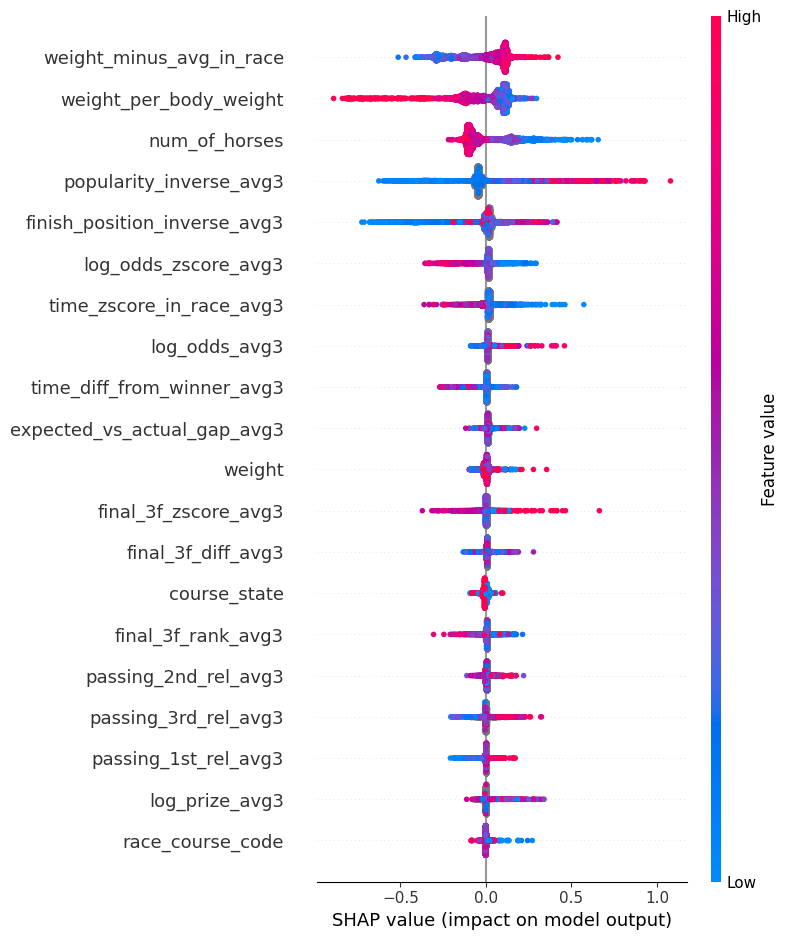

In [22]:
explainer = shap.TreeExplainer(ml_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

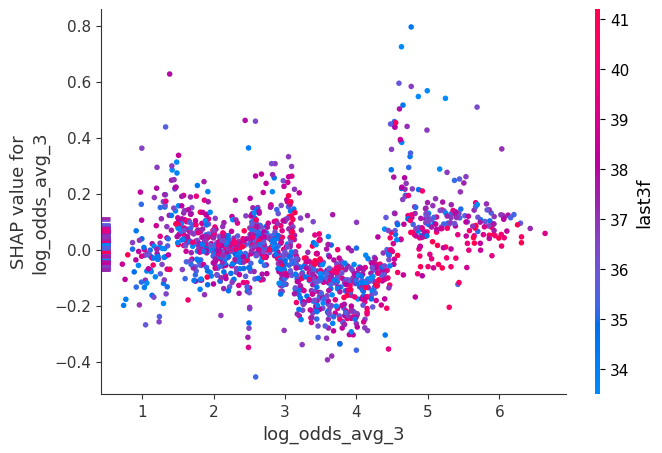

In [11]:
# 例：log_odds_avg_3 の依存プロット（色は last3f）
shap.dependence_plot("log_odds_avg_3", shap_values, X_test, interaction_index="last3f")

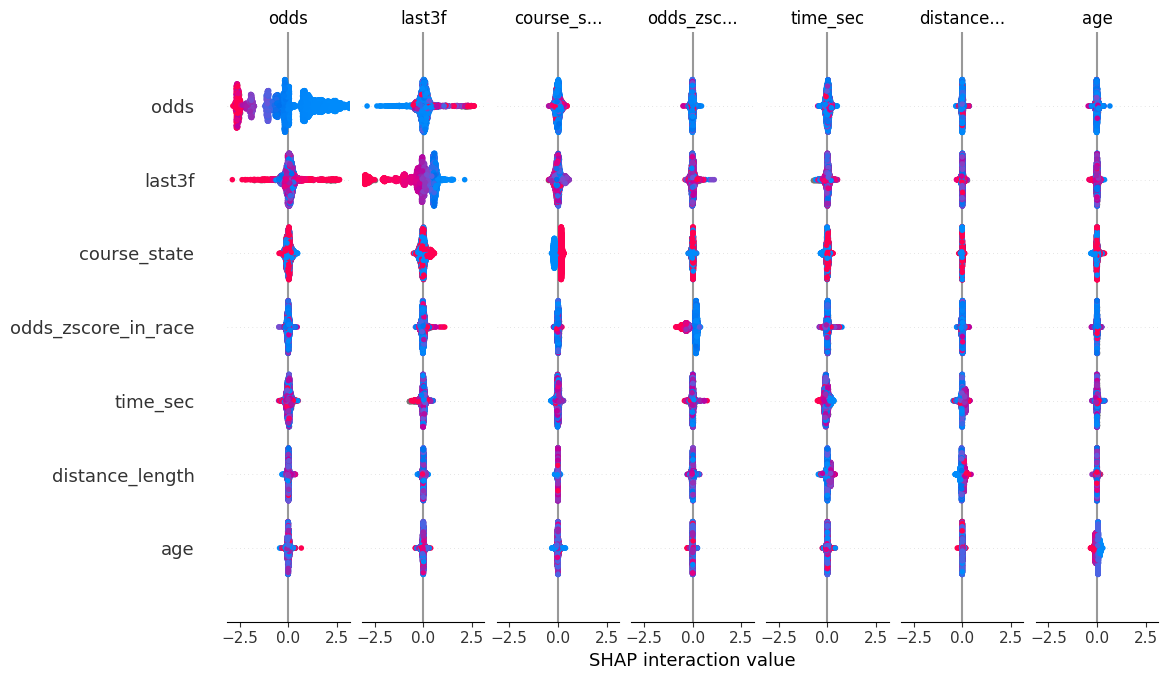

In [12]:
# SHAP interaction values を計算（時間がかかる）
interaction_values = explainer.shap_interaction_values(X_test)

# 例：odds × last3f の交互作用プロット
shap.summary_plot(interaction_values, X_test)

### ランキング学習

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [ ]:
params_rank = {
    'objective': 'lambdarank', # ランキング学習
    'metric': 'ndcg', # 評価指標(NDCG)
    'boosting_type': 'gbdt', # 勾配ブースティング
    'learning_rate': 0.1, # 学習率(小さいほど慎重に学習、ただし学習時間は長くなる)
    'num_leaves': 31, # 木の葉の数(複雑なモデルほど大きく)
    'verbose': -1, # 全てのログの出力を非表示
    'early_stopping_round': 30, # 30回連続で改善しなければ終了
    'num_boost_round': 300 # 最大100本の木を作成
}